# Preprocessing

Steps:
* Convert string values from text file to float64
* Replace NaN with zero

In [1]:
import ast

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()
plt.rcParams['font.size'] = 16
plt.rcParams['axes.facecolor'] = 'white'

%matplotlib inline

In [2]:
def from_disk(path_to_file):
    """Reads raw .txt data from disk and returns a pandas.DataFrame."""
    
    return pd.read_csv(path_to_file , delim_whitespace=True, index_col=0)

In [3]:
def prep_data(raw_data, log_transform=False):
    
    data = raw_data.infer_objects()
    
    if log_transform:
        transf_data = data.apply(lambda val: -np.log(val))
        transf_data.fillna(0, inplace=True)
        return transf_data
    
    else:    
        data.fillna(0, inplace=True)
        return data

In [4]:
def gen_stats(df):
    
    nrows, ncols = np.shape(df.values)
    # NOTE: Density is fraction of values eqial to zero
    output = [
        np.max(df.values), 
        np.min(df.values), 
        np.std(df.values),
        int(nrows), int(ncols), 
        int(np.count_nonzero(df.values))
    ]
    
    return output

In [5]:
def stats_table(datasets, index=None):
    
    _stats = []
    for dataset in datasets:
        _stats.append(gen_stats(dataset))
        
    df = pd.DataFrame(
        _stats, index=index,
        columns=['max', 'min', 'std', 'nrows', 'ncols', 'nonzeros']
    )
    
    return df

In [6]:
# Load raw data into memory
orig_pvalues = from_disk('./../data/test/emQTL_CorrelationMatrix_unfiltered_pvalues.txt')
# NOTE: Transpose to original shape
sel_pvalues = from_disk('./../data/test/emQTL_CorrelationMatrix_significant_pvalues.txt').T

orig_ccp = from_disk('./../data/test/emQTL_CorrelationMatrix_unfiltered_PCCs.txt')
# NOTE: Transpose to original shape
sel_ccp = from_disk('./../data/test/emQTL_CorrelationMatrix_significant_PCCs.txt').T

In [7]:
datasets = {
    'orig_pvalues': orig_pvalues, 'sel_pvalues': sel_pvalues, 
    'orig_ccp': orig_ccp, 'sel_ccp': sel_ccp
}
# Write column and row labels for each dataset to .txt file
for label, data in datasets.items():
    
    with open('./../data/data_ids/id_{}.txt'.format(label), 'w') as outfile:
        outfile.write('{0}\n'.format(label))
        outfile.write('{0}\n'.format(list(data.index)))
        outfile.write('{0}\n'.format(list(data.columns)))

In [8]:
# Running p-values preprocessing steps

# NOTE: Transposing original data to match shape of selected data
# QUESTION: Should rather transpose selected values back to original shape because 
# data was transposed when p-values were computed? Will transposing back result in heatmap 
# labels?
pvalues_prep = {
    'original': prep_data(orig_pvalues, log_transform=True).T, 
    'selected': prep_data(sel_pvalues, log_transform=True)
}

In [9]:
# Running pcc preprocessing steps

# NOTE: Transposing original data to match shape of selected data
pcc_prep = {
    'original': prep_data(orig_ccp, log_transform=False).T, 
    'selected': prep_data(sel_ccp, log_transform=False)
}

## Collecting target data characteristics

Write the characteristics of experimental data to file in order to generate synthetic test data with similar features. Collecting
* Max, min and std
* Data matrix size
* ...

In [10]:
df = stats_table(
    [
        pvalues_prep['original'], pvalues_prep['selected'],
        pcc_prep['original'], pcc_prep['selected']
    ],
    index=[
        'orig_prep_pvalues', 'sel_prep_pvalues',  
        'orig_prep_pcc', 'sel_prep_pcc'
    ]
)

df.to_csv(
    './data_characteristics.csv', sep='\t', encoding='utf-8'
)

# NOTE: The min value of p-value daa changes because NaNs are set to zero which 
# becomes the min value.
print('Statistics: \n{}'.format(df))

Statistics: 
                         max           min       std  nrows  ncols  nonzeros
orig_prep_pvalues  73.435290  7.079401e-09  5.889983  27561   2664  73422504
sel_prep_pvalues   73.435290  0.000000e+00  2.897937   2664  27561    739608
orig_prep_pcc       0.852443 -8.669647e-01  0.323260  27561   2664  73422504
sel_prep_pcc        0.852443 -8.669647e-01  0.063930   2664  27561    739608


## Visualizing processed data

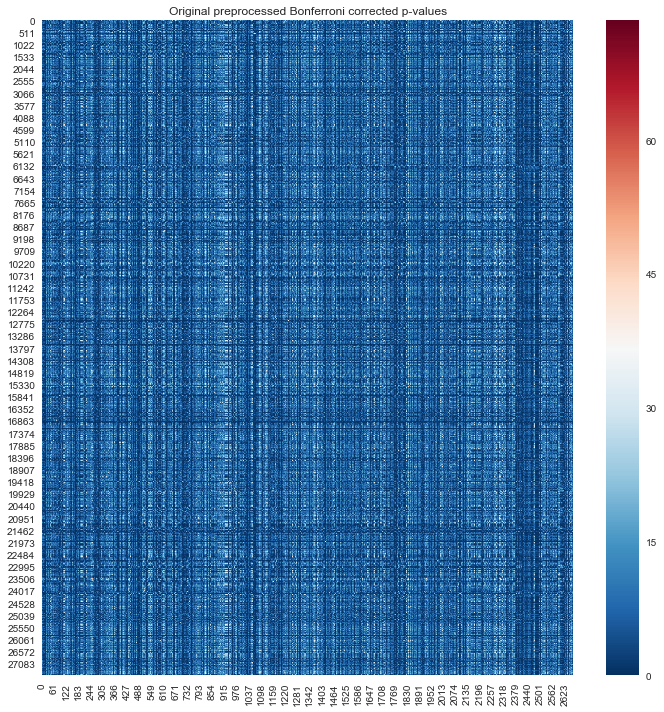

In [11]:
plt.figure(figsize=(10, 10))
plt.title('Original preprocessed Bonferroni corrected p-values')
sns.heatmap(
    pvalues_prep['original'].values, robust=True, 
    cmap=plt.cm.RdBu_r, fmt='f', 
    vmin=df.loc['orig_prep_pvalues', 'min'],
    vmax=df.loc['orig_prep_pvalues', 'max']
)
plt.tight_layout()
plt.savefig('./imgs/org_pvalues.png')

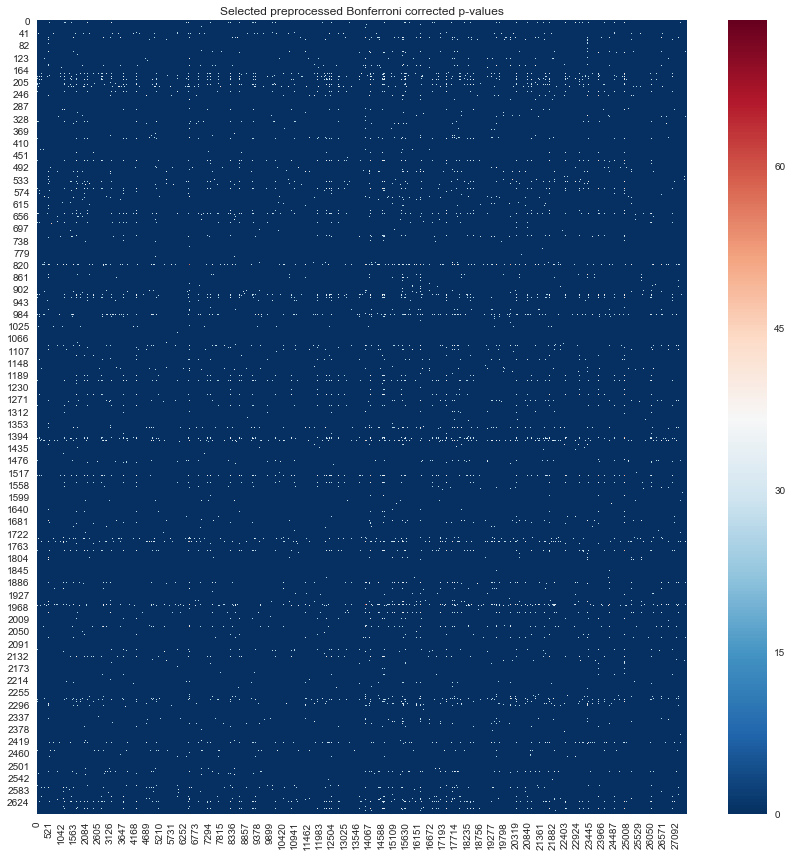

In [12]:
plt.figure(figsize=(12, 12))
plt.title('Selected preprocessed Bonferroni corrected p-values')
sns.heatmap(
    pvalues_prep['selected'].values, robust=True, 
    cmap=plt.cm.RdBu_r, fmt='f', 
    vmin=df.loc['sel_prep_pvalues', 'min'], 
    vmax=df.loc['sel_prep_pvalues', 'max']
)
plt.tight_layout()
plt.savefig('./../data/imgs/sel_pvalues.png')

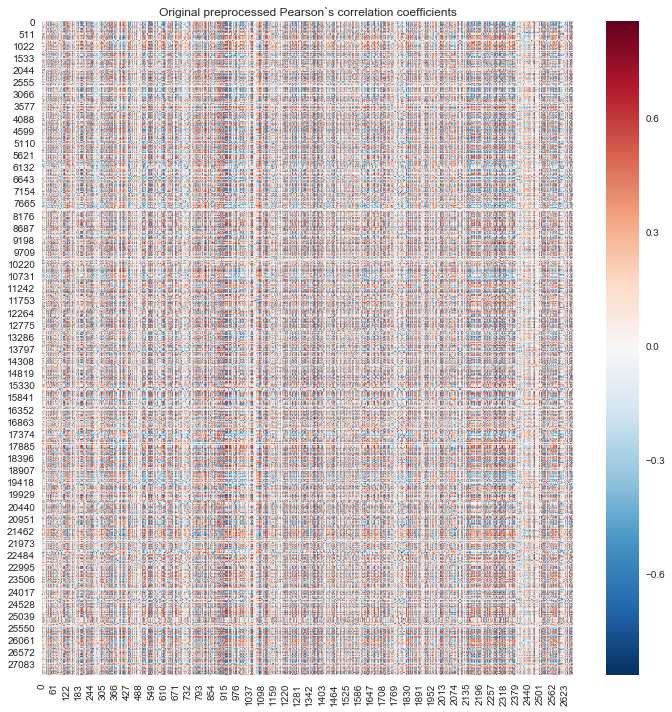

In [13]:
plt.figure(figsize=(10, 10))
plt.title('Original preprocessed Pearson`s correlation coefficients')
sns.heatmap(
    pcc_prep['original'].values, robust=True, 
    cmap=plt.cm.RdBu_r, fmt='f', 
    vmin=df.loc['orig_prep_pcc', 'min'], 
    vmax=df.loc['orig_prep_pcc', 'max']
)
plt.tight_layout()
plt.savefig('./../data/imgs/org_ccp.png')

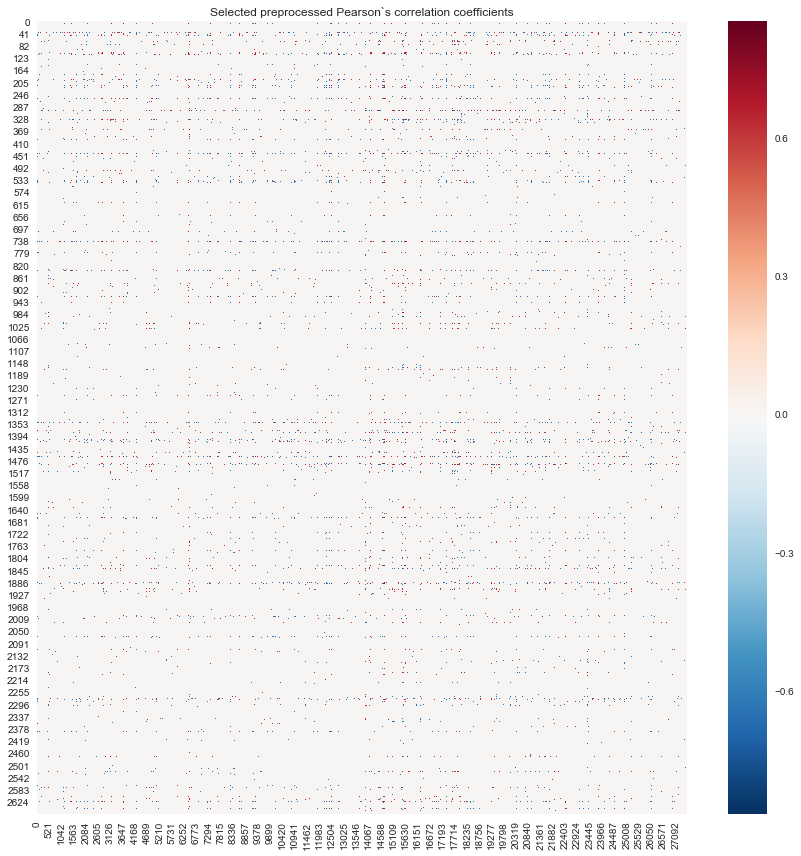

In [14]:
plt.figure(figsize=(12, 12))
plt.title('Selected preprocessed Pearson`s correlation coefficients')
sns.heatmap(
    pcc_prep['selected'].values, robust=True, 
    cmap=plt.cm.RdBu_r, fmt='f', 
    vmin=df.loc['sel_prep_pcc', 'min'], 
    vmax=df.loc['sel_prep_pcc', 'max']
)
plt.tight_layout()
plt.savefig('./../data/imgs/sel_ccp.png')

## Saving processed data to disk

In [15]:
def to_disk(path_to_file, data):
    
    data.to_csv(
        path_to_file, sep=',', 
        columns=list(data.columns), index=list(data.index)
    )

In [16]:
pvalue_data = {
    './../data/train/orig_pvalues_prep.csv': pvalues_prep['original'],
    './../data/train/sel_pvalues_prep.csv': pvalues_prep['selected']
}
for path, dataset in pvalue_data.items():
    to_disk(path, dataset)

In [18]:
pcc_data = {
    './../data/train/orig_pcc_prep.csv': pcc_prep['original'],
    './../data/train/sel_pcc_prep.csv': pcc_prep['selected']
}
for path, dataset in pcc_data.items():
    to_disk(path, dataset)